# Facebook stock price predictor

- 1 year observations and 3 days forecast
- Python server with Flask to have a front-end panel


In [1]:
import itertools    # libraries to be used
import warnings
import datetime
import pandas as pd
from pandas_datareader import data
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

# define one year period
start_date = '2017-02-01'
end_date = '2018-02-01'

# DataReader as API to load time series into a dataframe
df_stock = data.DataReader('FB', 'yahoo', start_date, end_date)

close = df_stock['Close']    # extracting closing price over the year


In [2]:
#df_stock.head(5)    # looking into dataframes

close.head(5)

#close.describe()    # statistical description of closing prices variable


Date
2017-02-01    133.229996
2017-02-02    130.839996
2017-02-03    130.979996
2017-02-06    132.059998
2017-02-07    131.839996
Name: Close, dtype: float64

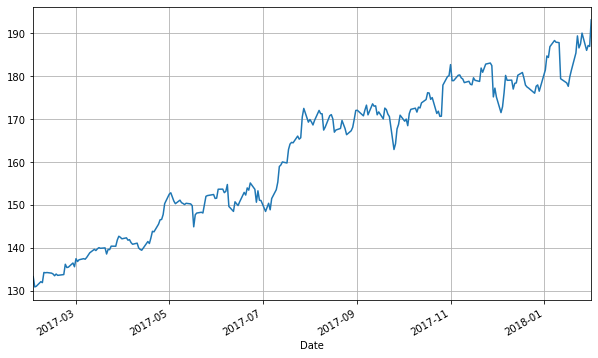

In [3]:
stock_plot = close.plot(grid=True, figsize=(10, 6))    # FB stocks plot of observed year


# Seasonal Auto Regressive Integrated Moving Average

- SARIMA(p,d,q)s model for three days forecasting

In [4]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 1) for x in list(itertools.product(p, d, q))]

warnings.filterwarnings("ignore") # specify to ignore warning messages

for param in pdq:
    for param_seasonal in seasonal_pdq:
            mod = sm.tsa.statespace.SARIMAX(close,order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('SARIMAX{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
                    

SARIMAX(0, 0, 0)x(0, 0, 0, 1) - AIC:3282.5027517778694
SARIMAX(0, 0, 0)x(0, 0, 1, 1) - AIC:2931.0207292889977
SARIMAX(0, 0, 0)x(0, 1, 0, 1) - AIC:1042.0847612233301
SARIMAX(0, 0, 0)x(0, 1, 1, 1) - AIC:1040.8951322732282
SARIMAX(0, 0, 0)x(1, 0, 0, 1) - AIC:1045.2210800976375
SARIMAX(0, 0, 0)x(1, 0, 1, 1) - AIC:1042.0676715786576
SARIMAX(0, 0, 0)x(1, 1, 0, 1) - AIC:1044.04404968141
SARIMAX(0, 0, 0)x(1, 1, 1, 1) - AIC:1042.8951150437638
SARIMAX(0, 0, 1)x(0, 0, 0, 1) - AIC:2931.0207292889977
SARIMAX(0, 0, 1)x(0, 0, 1, 1) - AIC:2642.3770630708805
SARIMAX(0, 0, 1)x(0, 1, 0, 1) - AIC:1040.8951322732282
SARIMAX(0, 0, 1)x(0, 1, 1, 1) - AIC:1039.4307844274067
SARIMAX(0, 0, 1)x(1, 0, 0, 1) - AIC:1042.061307493011
SARIMAX(0, 0, 1)x(1, 0, 1, 1) - AIC:1040.8263569639907
SARIMAX(0, 0, 1)x(1, 1, 0, 1) - AIC:1042.895124290263
SARIMAX(0, 0, 1)x(1, 1, 1, 1) - AIC:1039.9573137216998
SARIMAX(0, 1, 0)x(0, 0, 0, 1) - AIC:1042.0847612233301
SARIMAX(0, 1, 0)x(0, 0, 1, 1) - AIC:1040.8951322732282
SARIMAX(0, 1, 

#### looking at obtained AIC values
- ARIMA(1, 1, 1)x(0, 1, 1, 1)1 - AIC:1036.37 has the lowest value
- prediction will be based on this model

In [5]:
fin_mod = sm.tsa.statespace.SARIMAX(close,
                                    order=(1, 1, 1),
                                    seasonal_order=(0, 1, 1, 1),
                                    enforce_stationarity=False,
                                    enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])    # realistic coef values and p-value < 0.05 validate the model


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4315      0.042     10.240      0.000       0.349       0.514
ma.L1         -0.9138      0.018    -51.137      0.000      -0.949      -0.879
ar.S.L1        0.4315      0.042     10.240      0.000       0.349       0.514
ma.S.L1       -0.9138      0.018    -51.137      0.000      -0.949      -0.879
sigma2         3.7467      0.211     17.776      0.000       3.334       4.160


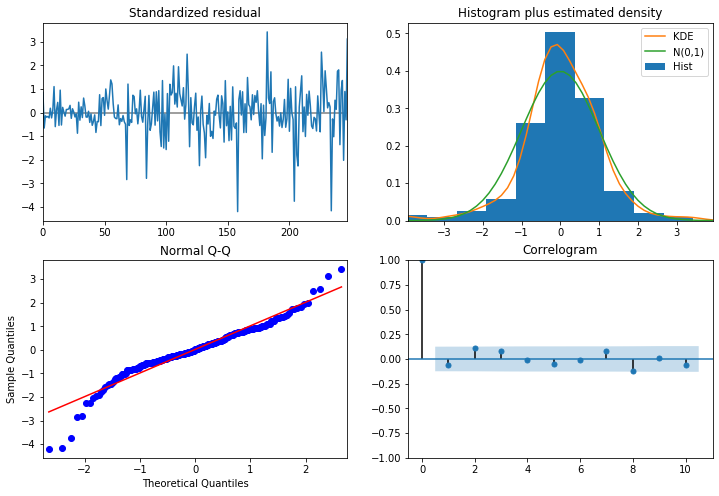

In [6]:
results.plot_diagnostics(figsize=(12, 8))
plt.show()

# possible good fitting
# residuals normally distributed N(0,1) by KDE curve
# strong linear trend in Q-Q plot with outliers at the extremes
# stationary time series with low correation and no seasonality


## Supervised prediction

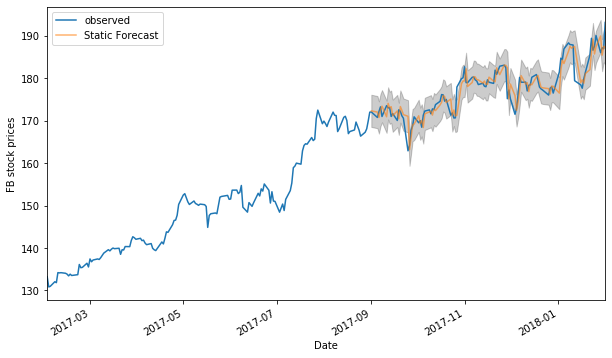

In [7]:
# static prediction

pred_static = results.get_prediction(start=pd.to_datetime('2017-09-01'), dynamic=False)    # from September 2018
pred_static_ci = pred_static.conf_int()

ax = close.plot(label='observed', figsize=(10, 6))
pred_static.predicted_mean.plot(ax=ax, label='Static Forecast', alpha=.6)

ax.fill_between(pred_static_ci.index,
                pred_static_ci.iloc[:, 0],
                pred_static_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('FB stock prices')
plt.legend()

plt.show()


In [8]:
fb_forecasted = pred_static.predicted_mean
fb_truth = close['2017-09-01':]

# Compute the mean square error
mse = ((fb_forecasted - fb_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

# high mse due to the short period analyzed


The Mean Squared Error of our forecasts is 5.56


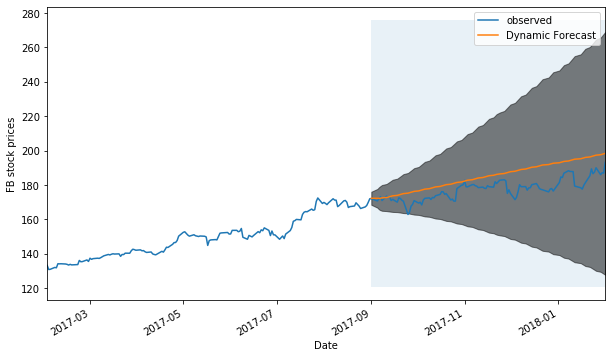

In [9]:
pred_dynamic = results.get_prediction(start=pd.to_datetime('2017-09-01'), dynamic=True, full_results=True)    # dynamic prediction
pred_dynamic_ci = pred_dynamic.conf_int()

ax = close.plot(label='observed', figsize=(10, 6))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_ci.index,
                pred_dynamic_ci.iloc[:, 0],
                pred_dynamic_ci.iloc[:, 1], color='k', alpha=.5)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2017-09-01'), close.index[-1],
                 alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('FB stock prices')

plt.legend()
plt.show()


In [14]:
# Extract the predicted and true values of our time series
fb_forecasted = pred_dynamic.predicted_mean
fb_truth = close['2017-09-01':]

# Compute the mean square error
mse = ((fb_forecasted - fb_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

# very high mse value due to the too short period


The Mean Squared Error of our forecasts is 77.28


## future three days prediction

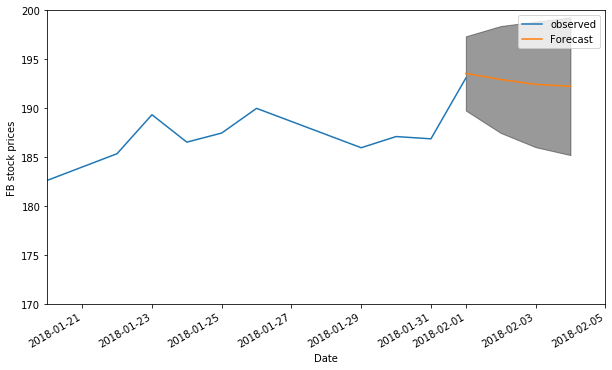

<Figure size 432x288 with 0 Axes>

In [11]:
# Get forecast 3 days ahead in future
pred_uc = results.get_forecast(steps=4)
# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

# set days
days = pd.date_range("2018-02-01", "2018-02-04")
pred_ci['Date'] = pd.to_datetime(days)
pred_ci.set_index('Date', inplace=True)

# calculate mean
pred_ci['Mean'] = pred_ci.mean(axis=1)

ax = close.plot(label='observed', figsize=(10, 6))
pred_ci['Mean'].plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.4)

plt.axis(['2018-01-20','2018-02-05',170,200])

ax.set_xlabel('Date')
ax.set_ylabel('FB stock prices')

plt.legend()
plt.show()

#plt.savefig("pred.png")    # for Flask


In [12]:
pred_ci    # predicted values and relative means
#pred_dynamic_ci


,lower Close,upper Close,Mean
Date,,,
2018-02-01,189.773544,197.361086,193.567315
2018-02-02,187.488215,198.409210,192.948712
2018-02-03,186.035874,198.863591,192.449732
2018-02-04,185.226276,199.289702,192.257989


In [13]:
# define few days period to verify prediction
start_date = '2018-02-01'
end_date = '2018-02-10'

# DataReader as API to load real values into a dataframe
df_stock_test = data.DataReader('FB', 'yahoo', start_date, end_date)

close_test = df_stock_test['Close']
close_test.head(8)

# predicted values close to real ones
# slightly negative trend in the following week catched by prediction


Date
2018-02-01    193.089996
2018-02-02    190.279999
2018-02-05    181.259995
2018-02-06    185.309998
2018-02-07    180.179993
2018-02-08    171.580002
2018-02-09    176.110001
Name: Close, dtype: float64